# Lab 5: Transfer learning.

Thanks to their capability to learn generalizable descriptors directly from images, deep Convolutional Neural Networks (CNNs) seem the ideal solution to most pattern recognition problems. On the other hand, to learn the image representation, CNNs need huge sets of annotated samples that are unfeasible in many every-day scenarios. This is the case, for example, of Computer-Aided Diagnosis (CAD) systems for digital pathology, where additional challenges are
posed by the high variability of the cancerous tissue characteristics. 
In this notebooks you are going to implement 4 different training paradigms leveraging CNNs:


1.   Training from scratch
2.   Features extractor followed by SVM
3.   Fine tuning




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import and settings

In [2]:
import os
import cv2
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [3]:
!git clone https://github.com/frpnz/dataset-BIOSTEC2018.git
ROOTDIR_DATASET = "/content/dataset-BIOSTEC2018/crc_images"
IMAGE_SIZE = 32
NUM_CLASSES = 3

fatal: destination path 'dataset-BIOSTEC2018' already exists and is not an empty directory.


## Utils

In [4]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Assignment #1: create two tensorflow dataset for train and test.
Leverage the API [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [5]:
train_dir = os.path.join(ROOTDIR_DATASET, 'train')
test_dir = os.path.join(ROOTDIR_DATASET, 'test')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(IMAGE_SIZE,IMAGE_SIZE))

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


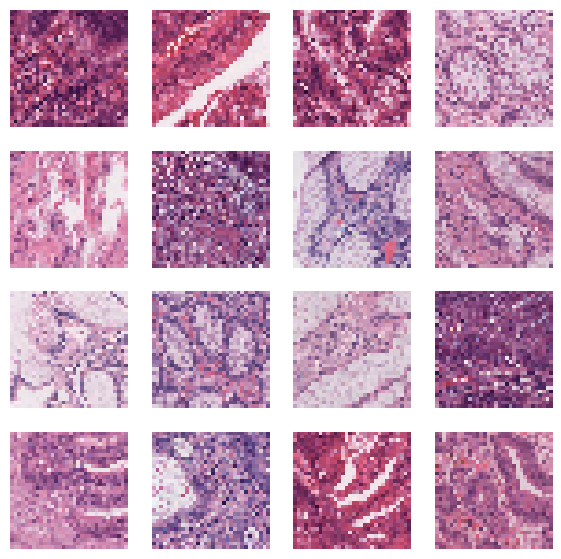

In [6]:
j = 0
fig, ax = plt.subplots(4, 4, figsize=(7, 7))
ax = ax.ravel()
for batch in train_ds.take(1):
    images = batch[0]
    labels = batch[1]
    for image, label in zip(images, labels):
        if j >= 16:
            break
        image = image.numpy().astype(np.uint8)
        ax[j].imshow(image)
        ax[j].axis("off")
        j += 1

# Assignment #2: dataset preparation
1.   Normalize images in the range [0, 1]
2.   Prepare the input pipeline via tf.data.Dataset methods



In [7]:
def process_data(image, label):
    return tf.cast(image, tf.float32) / 255. , tf.one_hot(label, NUM_CLASSES, name='label', axis=-1)

train_ds = train_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

# Assignment #3: train a VGG16 from scratch for 50 epochs

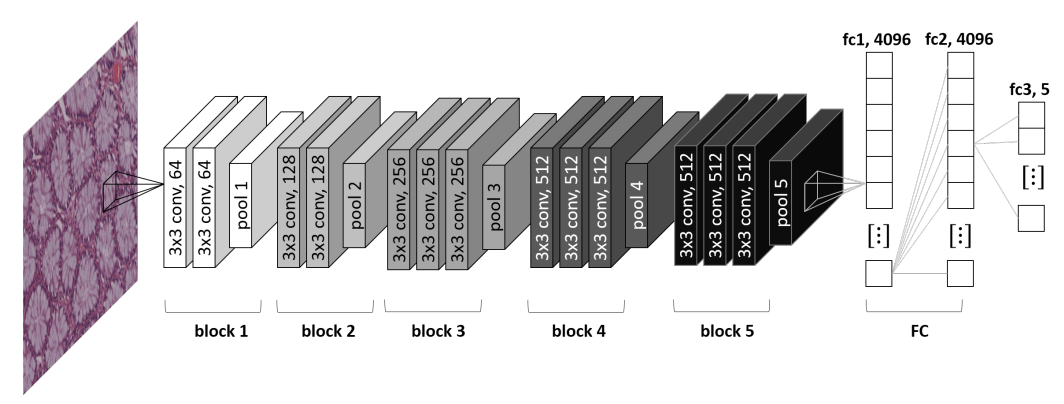

In [8]:
vgg16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling=None,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

vgg16.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
vgg16.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics="accuracy")

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [9]:
def scheduler(epoch, lr):
    if epoch < 45:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [13]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = vgg16.fit(train_ds, epochs=50, callbacks = [callback])

#aumentando le epoche si ha una accuracy più precisa

Epoch 1/50
282/282 [==============================] - 9s 31ms/step - loss: 0.3730 - accuracy: 0.8601 - lr: 0.0100
Epoch 2/50
282/282 [==============================] - 8s 30ms/step - loss: 0.3580 - accuracy: 0.8651 - lr: 0.0100
Epoch 3/50
282/282 [==============================] - 9s 30ms/step - loss: 0.3467 - accuracy: 0.8701 - lr: 0.0100
Epoch 4/50
282/282 [==============================] - 8s 30ms/step - loss: 0.3345 - accuracy: 0.8752 - lr: 0.0100
Epoch 5/50
282/282 [==============================] - 9s 30ms/step - loss: 0.3222 - accuracy: 0.8822 - lr: 0.0100
Epoch 6/50
282/282 [==============================] - 8s 29ms/step - loss: 0.3128 - accuracy: 0.8870 - lr: 0.0100
Epoch 7/50
282/282 [==============================] - 8s 30ms/step - loss: 0.3016 - accuracy: 0.8931 - lr: 0.0100
Epoch 8/50
282/282 [==============================] - 8s 30ms/step - loss: 0.2917 - accuracy: 0.8993 - lr: 0.0100
Epoch 9/50
282/282 [==============================] - 8s 30ms/step - loss: 0.2830 - accu

## Plot train loss and accuracy among epochs (see [History](tf.keras.callbacks.History) object) 

In [14]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 282}

Text(0.5, 1.0, 'Loss')

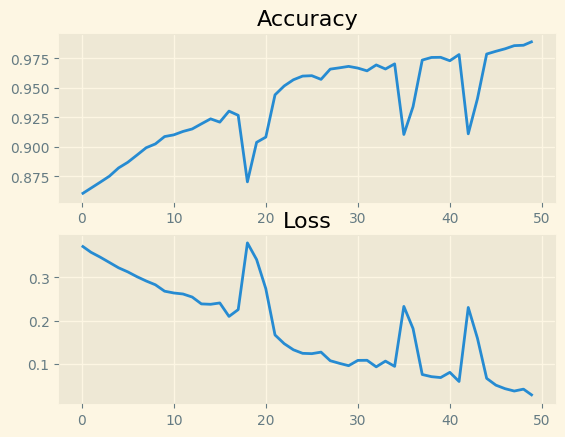

In [15]:
plt.style.use("Solarize_Light2")
fig, ax = plt.subplots(2, 1)
ax[0].plot([e for e in range(history.params['epochs'])], history.history['accuracy'])
ax[0].set_title('Accuracy')
ax[1].plot([e for e in range(history.params['epochs'])], history.history['loss'])
ax[1].set_title('Loss')

# Assignment #4: extract features from VGG16 pre-trained on ImageNet and then train and test a downstream SVM.

Pipeline:
1. Features extraction from the CNN
2. PCA
3. SVM training and test

N.B. Do not shuffle train and test in order to extract labels in the correct order.

In [ ]:
train_ds = [...]

test_ds = [...]

In [ ]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = [...]
test_ds = [...]

In [ ]:
vgg16 = [...]

In [ ]:
labels_train = np.concatenate([np.argmax(y, axis=1) for _, y in train_ds], axis=0)
labels_test = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

# Assignment #5: Fine tune the VGG16 pre-trained on ImageNet.

In [ ]:
train_ds = [...]

test_ds = [...]

In [ ]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return  tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = [...]
test_ds = [...]

In [ ]:
base_model = [...]